<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Importing-Libraries-&amp;-Initialization" data-toc-modified-id="Importing-Libraries-&amp;-Initialization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing Libraries &amp; Initialization</a></span></li><li><span><a href="#Required-Input" data-toc-modified-id="Required-Input-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Required Input</a></span></li></ul></li><li><span><a href="#Data-Loading-and-transforms" data-toc-modified-id="Data-Loading-and-transforms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Loading and transforms</a></span><ul class="toc-item"><li><span><a href="#Loading-the-CSV" data-toc-modified-id="Loading-the-CSV-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading the CSV</a></span></li><li><span><a href="#Defining-Transforms" data-toc-modified-id="Defining-Transforms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Defining Transforms</a></span></li><li><span><a href="#Setting-up-custom-Dataset-&amp;-DataLoader" data-toc-modified-id="Setting-up-custom-Dataset-&amp;-DataLoader-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Setting up custom Dataset &amp; DataLoader</a></span></li><li><span><a href="#Checking-Images-and-Labels-before-feeding" data-toc-modified-id="Checking-Images-and-Labels-before-feeding-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Checking Images and Labels before feeding</a></span></li></ul></li><li><span><a href="#Defining-the-Model" data-toc-modified-id="Defining-the-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Defining the Model</a></span><ul class="toc-item"><li><span><a href="#Train-Model-Function" data-toc-modified-id="Train-Model-Function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train Model Function</a></span></li><li><span><a href="#Visualize-Model-Function-to-see-the-output" data-toc-modified-id="Visualize-Model-Function-to-see-the-output-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualize Model Function to see the output</a></span></li><li><span><a href="#Loading-pretrained-weights-and-Model-Initializations" data-toc-modified-id="Loading-pretrained-weights-and-Model-Initializations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Loading pretrained weights and Model Initializations</a></span></li></ul></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Saving the model</a></span></li></ul></div>

# Face Attribute Estimation Using Transfer Learning

## Initialization
### Importing Libraries & Initialization

In [1]:
from imutils import paths
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
import time
import os
import copy

plt.ion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Required Input
* dataset_path
* csv_path
* classifier_att
* output_model_name
* Val_split 

In [14]:
dataset_path = "A:/Datasets/celeba_dataset/celeba/"
csv_path = "A:/Datasets/celeba_dataset/attributes_celeba.csv"
classifier_att = "No_Beard"  # One attribute at a time
output_model_name = "../model/model_beard2.pt"
pre_trained_model = "../model/model_beard.pt"
val_split = 0.1
epochs = 10
batch_size = 4

## Data Loading and transforms

### Loading the CSV

In [3]:
df = pd.read_csv(csv_path)
df.tail()

,images,No_Beard,Mustache,Male,Eyeglasses
202594,202595.jpg,1,-1,-1,-1
202595,202596.jpg,1,-1,1,-1
202596,202597.jpg,1,-1,1,1
202597,202598.jpg,1,-1,-1,-1
202598,202599.jpg,1,-1,-1,-1


In [4]:
df = pd.DataFrame({"images": df['images'], classifier_att: df[classifier_att]})
df

,images,No_Beard
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,1
3,000004.jpg,1
4,000005.jpg,1
...,...,...
202594,202595.jpg,1
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,1


In [5]:
df_on = df[df[classifier_att]==1]
df_off = df[df[classifier_att]==-1]
min_num = np.min([len(df_on), len(df_off)])
print("No. of Images per class:", min_num)
df_on = df_on[0:min_num]
df_off = df_off[0:min_num]
print("df_on:", len(df_on),"df_off",len(df_off))
df = pd.concat([df_on, df_off], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

No. of Images per class: 33441
df_on: 33441 df_off 33441


,images,No_Beard
0,113719.jpg,-1
1,141941.jpg,-1
2,062764.jpg,-1
3,056005.jpg,-1
4,147344.jpg,-1
...,...,...
66877,185110.jpg,-1
66878,005967.jpg,-1
66879,033420.jpg,-1
66880,168434.jpg,-1


In [6]:
df_train, df_val = df[0:int(len(df)*(1 - val_split))], df[int(len(df)*(1 - val_split)) : len(df)]
df_dict = {'train':df_train, 'val': df_val}
print("TRAIN_LENGTH:",len(df_train),"  TEST_LENGTH:", len(df_val))
df_val = df_val.reset_index()
del df_val['index']
df_train

TRAIN_LENGTH: 60193   TEST_LENGTH: 6689


,images,No_Beard
0,113719.jpg,-1
1,141941.jpg,-1
2,062764.jpg,-1
3,056005.jpg,-1
4,147344.jpg,-1
...,...,...
60188,012440.jpg,1
60189,186095.jpg,-1
60190,000144.jpg,-1
60191,011493.jpg,1


In [7]:
df_val

,images,No_Beard
0,059193.jpg,-1
1,006115.jpg,1
2,153377.jpg,-1
3,139149.jpg,-1
4,169862.jpg,-1
...,...,...
6684,185110.jpg,-1
6685,005967.jpg,-1
6686,033420.jpg,-1
6687,168434.jpg,-1


### Defining Transforms

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Setting up custom Dataset & DataLoader
* [To get familiar with Pytorch datasets and dataloaders from this documentation](https://pytorch.org/docs/stable/data.html#dataset-types)
* As we have a csv file and not a folder structure, we cannot use torch vision imagefolder function. Hence, we are building a custom Dataset and a DataLoader

In [9]:
class CelebDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(dataset_path+self.image_paths[idx])
        if self.transform:
            img = self.transform(img)
        lab = self.labels[idx]
        if lab == -1:
            label = 0
        else:
            label = 1
        return img, label

In [10]:
image_datasets = {}
image_datasets['train'] = CelebDataset(df_train['images'], df_train[classifier_att],data_transforms['train'])
image_datasets['val'] = CelebDataset(df_val['images'], df_val[classifier_att],data_transforms['val'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [("n_"+str(classifier_att)), classifier_att]
print(dataset_sizes, class_names)

{'train': 60193, 'val': 6689} ['n_No_Beard', 'No_Beard']


### Checking Images and Labels before feeding

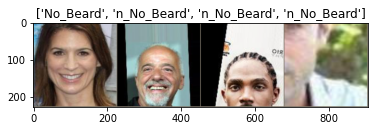

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Defining the Model
### Train Model Function

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            count = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                count = count +1 
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if count%100 == 0:
                    print("LOSS at STEP : ",count,loss.item(), datetime.datetime.now(), running_corrects.double()/(count*4))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualize Model Function to see the output

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Loading pretrained weights and Model Initializations

In [15]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
if pre_trained_model:
    model_ft = torch.load(pre_trained_model)
    print("Loading the pretrained model at", pre_trained_model)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

Loading the pretrained model at ../model/model_beard.pt


In [16]:
pytorch_total_params = sum(p.numel() for p in model_ft.parameters())
print("Total Model Parameters:",pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print("Total Trainable Parameters",pytorch_trainable_params)

Total Model Parameters: 11177538
Total Trainable Parameters 1026


In [17]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training the model

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
LOSS at STEP :  100 0.33804023265838623 2020-04-21 08:41:19.650533 tensor(0.7650, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  200 0.5181286334991455 2020-04-21 08:41:30.110758 tensor(0.7263, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  300 1.442055583000183 2020-04-21 08:41:40.514295 tensor(0.7233, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  400 0.13190722465515137 2020-04-21 08:41:51.160652 tensor(0.7137, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  500 0.41983112692832947 2020-04-21 08:42:01.611064 tensor(0.7095, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  600 0.6648803949356079 2020-04-21 08:42:12.259208 tensor(0.7158, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  700 0.3422653079032898 2020-04-21 08:42:22.791364 tensor(0.7250, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  800 0.43024423718452454 2020-04-21 08:42:33.491461 tensor(0.7225, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  900 0.74

LOSS at STEP :  6900 0.3628903031349182 2020-04-21 08:54:10.679631 tensor(0.7130, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7000 0.4859473705291748 2020-04-21 08:54:24.071823 tensor(0.7131, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7100 0.3630678057670593 2020-04-21 08:54:37.520864 tensor(0.7133, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7200 0.5609778761863708 2020-04-21 08:54:50.908071 tensor(0.7135, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7300 0.6185089349746704 2020-04-21 08:55:04.793942 tensor(0.7134, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7400 0.9891877174377441 2020-04-21 08:55:18.820439 tensor(0.7134, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7500 0.39367473125457764 2020-04-21 08:55:33.247866 tensor(0.7132, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7600 0.09801091253757477 2020-04-21 08:55:48.563914 tensor(0.7131, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  7700 0.428587615489959

LOSS at STEP :  13700 0.32706910371780396 2020-04-21 09:09:55.056158 tensor(0.7124, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  13800 1.5944960117340088 2020-04-21 09:10:08.643828 tensor(0.7123, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  13900 0.4734725058078766 2020-04-21 09:10:22.182628 tensor(0.7123, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14000 0.5152347087860107 2020-04-21 09:10:36.311849 tensor(0.7122, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14100 0.1933394819498062 2020-04-21 09:10:50.492936 tensor(0.7122, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14200 0.12141743302345276 2020-04-21 09:11:04.909388 tensor(0.7118, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14300 0.25498294830322266 2020-04-21 09:11:18.855101 tensor(0.7120, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14400 1.3625880479812622 2020-04-21 09:11:32.363982 tensor(0.7122, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14500 0.55662

LOSS at STEP :  3900 0.13428133726119995 2020-04-21 09:24:23.237867 tensor(0.7138, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4000 0.2570854723453522 2020-04-21 09:24:34.761057 tensor(0.7143, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4100 1.09047532081604 2020-04-21 09:24:46.100738 tensor(0.7141, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4200 0.9758245348930359 2020-04-21 09:24:57.525192 tensor(0.7135, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4300 0.3716955780982971 2020-04-21 09:25:09.166067 tensor(0.7135, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4400 0.10933475196361542 2020-04-21 09:25:20.545641 tensor(0.7141, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4500 0.9121348857879639 2020-04-21 09:25:31.895295 tensor(0.7134, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4600 0.400493323802948 2020-04-21 09:25:43.306783 tensor(0.7139, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  4700 0.30182403326034546 

LOSS at STEP :  10800 0.5050292015075684 2020-04-21 09:37:33.495312 tensor(0.7153, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  10900 0.925071120262146 2020-04-21 09:37:44.910787 tensor(0.7155, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  11000 0.2076716423034668 2020-04-21 09:37:56.319285 tensor(0.7158, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  11100 0.6954749226570129 2020-04-21 09:38:07.711825 tensor(0.7157, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  11200 0.404743492603302 2020-04-21 09:38:19.120321 tensor(0.7154, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  11300 0.8949103951454163 2020-04-21 09:38:30.561730 tensor(0.7153, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  11400 0.6118326187133789 2020-04-21 09:38:41.947288 tensor(0.7155, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  11500 0.10228075087070465 2020-04-21 09:38:53.398670 tensor(0.7153, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  11600 0.515605390

LOSS at STEP :  1000 1.252752661705017 2020-04-21 09:50:41.008633 tensor(0.7130, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1100 0.634699285030365 2020-04-21 09:50:52.419124 tensor(0.7139, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1200 0.2697417140007019 2020-04-21 09:51:03.913393 tensor(0.7119, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1300 0.18486353754997253 2020-04-21 09:51:15.459520 tensor(0.7108, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1400 0.31430917978286743 2020-04-21 09:51:26.928860 tensor(0.7095, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1500 0.31216663122177124 2020-04-21 09:51:38.214680 tensor(0.7102, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1600 0.8714761734008789 2020-04-21 09:51:49.649106 tensor(0.7116, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1700 0.14005297422409058 2020-04-21 09:52:01.047631 tensor(0.7091, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  1800 0.214698970317840

LOSS at STEP :  7900 0.786859929561615 2020-04-21 10:04:10.600686 tensor(0.7121, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8000 0.2823747992515564 2020-04-21 10:04:22.392091 tensor(0.7129, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8100 0.40489277243614197 2020-04-21 10:04:34.033071 tensor(0.7131, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8200 0.4372420608997345 2020-04-21 10:04:45.738349 tensor(0.7135, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8300 0.36422228813171387 2020-04-21 10:04:57.413291 tensor(0.7137, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8400 0.44843876361846924 2020-04-21 10:05:09.066443 tensor(0.7135, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8500 0.8232210278511047 2020-04-21 10:05:20.798132 tensor(0.7135, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8600 0.7452637553215027 2020-04-21 10:05:32.611491 tensor(0.7135, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  8700 0.784172892570495

LOSS at STEP :  14700 0.6174312829971313 2020-04-21 10:17:25.840877 tensor(0.7104, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14800 0.1700761318206787 2020-04-21 10:17:37.783354 tensor(0.7106, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  14900 0.5270756483078003 2020-04-21 10:17:49.519230 tensor(0.7105, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  15000 0.21144281327724457 2020-04-21 10:18:01.173675 tensor(0.7105, device='cuda:0', dtype=torch.float64)
train Loss: 0.5767 Acc: 0.7104
LOSS at STEP :  100 0.9869062900543213 2020-04-21 10:18:18.515655 tensor(0.8500, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  200 0.5963153839111328 2020-04-21 10:18:30.023188 tensor(0.8137, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  300 1.3338706493377686 2020-04-21 10:18:41.478902 tensor(0.8200, device='cuda:0', dtype=torch.float64)
LOSS at STEP :  400 0.06012947857379913 2020-04-21 10:18:53.453756 tensor(0.8119, device='cuda:0', dtype=torch.float64)
LOSS at

## Saving the model

In [19]:
torch.save(model_ft, output_model_name)